In [1]:
import pandas as pd 
df = pd.read_csv('fully_cleaned_menu_outliers.csv').copy()
df.tail()

,order_date,year,month,month_name,sales_qty,sales_amount,user_id,Resturant_id,Resturant_Name,Cuisine,Location,City,Ratings
69557,2022-07-17 23:25:11,2022,7,July,40,44680,45633,2030,The Salt Grill - Hilton Bangalore Embassy Golf...,"European, Mediterranean, Salad",Domlur,Bangalore,4.100000
69558,2024-09-17 10:30:03,2024,9,September,10,1200,15337,1422,City Of Joy,Bengali,"Alaknanda, New Delhi",Delhi NCR,4.300000
69559,2025-05-25 12:19:14,2025,5,May,10,3560,64728,4855,Mums Combo Raja,Bakery,"B/100/H/15, Kavi Sukanto Sarani, Beliaghata, K...",Kolkata,4.400000
69560,2021-09-22 08:03:47,2021,9,September,50,68520,34594,4988,Red Chilli,"North Indian, Chinese","Belgachia Road, Manmath Nath Dutta Road, Belga...",Kolkata,3.700000
69561,2021-04-22 23:00:09,2021,4,April,10,830,28908,1649,Burger King,"Burger, , Fast Food, , Desserts, , Beverages","Lower A Sector, Near C Sector, Itanagar",Itanagar,3.929282


In [2]:
## Scenario 1 - For Ratings .

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

# ----------------------------
# CLEAN CATEGORICAL TEXT
# ----------------------------
df['City'] = df['City'].str.strip()
df['Cuisine'] = df['Cuisine'].str.strip()

# ----------------------------
# LABEL ENCODING
# ----------------------------
le_city = LabelEncoder()
le_cuisine = LabelEncoder()

df['City_encoded'] = le_city.fit_transform(df['City'])
df['Cuisine_encoded'] = le_cuisine.fit_transform(df['Cuisine'])

# ----------------------------
# CREATE BINS FOR STRATIFICATION
# ----------------------------

df['rating_bins'] = pd.cut(
    df['Ratings'],
    bins=[0, 3.5, 4.2, 5.1],
    labels=[0, 1, 2]
)

# ----------------------------
# SELECT FEATURES & TARGET
# ----------------------------
X = df[['year', 'month', 'sales_qty', 'sales_amount',
        'City_encoded', 'Cuisine_encoded']]

y = df['Ratings']   # regression target

# ----------------------------
# STRATIFIED SHUFFLE SPLIT
# ----------------------------
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(df, df['rating_bins']):
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]

# ----------------------------
# TRAIN MODEL
# ----------------------------
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# ----------------------------
# PREDICT
# ----------------------------
y_pred = model.predict(X_test)

# ----------------------------
# METRICS
# ----------------------------
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)

print("R² Score:", r2)
print("RMSE:", rmse)


R² Score: 0.1604105816592889
RMSE: 0.19064699332522544


In [3]:
## Let's check on to the new sample data 

sample = pd.DataFrame({
    'year': [2024],
    'month': [7],
    'sales_qty': [20],
    'sales_amount': [1500],
    'City_encoded': le_city.transform(['Kolkata']),
    'Cuisine_encoded': le_cuisine.transform(['Burgers'])
})

predicted_rating = model.predict(sample)
print("Predicted Rating:", predicted_rating[0])


Predicted Rating: 3.6096250000000007


In [4]:
## Scenario 2 - For monthly sales

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

# ------------------------------------
# 1. Clean text columns
# ------------------------------------
df['City'] = df['City'].str.strip()
df['Cuisine'] = df['Cuisine'].str.strip()

# ------------------------------------
# 2. Label Encoding
# ------------------------------------
le_city = LabelEncoder()
le_cuisine = LabelEncoder()

df['City_encoded'] = le_city.fit_transform(df['City'])
df['Cuisine_encoded'] = le_cuisine.fit_transform(df['Cuisine'])

# ------------------------------------
# 3. Create sales bins for stratification
# ------------------------------------
df['sales_bins'] = pd.cut(
    df['sales_amount'],
    bins=[-1, 500, 1500, df['sales_amount'].max()],
    labels=[0, 1, 2]
)

# ------------------------------------
# 4. Select features
# ------------------------------------
X = df[['year', 'month', 'sales_qty', 'Ratings', 
        'City_encoded', 'Cuisine_encoded']]

y = df['sales_amount']

# ------------------------------------
# 5. Stratified Shuffle Split
# ------------------------------------
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, test_idx in split.split(df, df['sales_bins']):
    X_train = X.iloc[train_idx]
    y_train = y.iloc[train_idx]
    X_test = X.iloc[test_idx]
    y_test = y.iloc[test_idx]

# ------------------------------------
# 6. Train the Sales Prediction Model
# ------------------------------------
model_sales = RandomForestRegressor(
    n_estimators=250,
    random_state=42
)

model_sales.fit(X_train, y_train)

# ------------------------------------
# 7. Predictions
# ------------------------------------
y_pred = model_sales.predict(X_test)

# ------------------------------------
# 8. Evaluation Metrics
# ------------------------------------
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)

print("Sales Prediction Model Results:")
print("R² Score:", r2)
print("RMSE:", rmse)


Sales Prediction Model Results:
R² Score: 0.3003113460435487
RMSE: 89787074725.87079


In [5]:
sample = pd.DataFrame({
    'year': [2024],
    'month': [7],
    'sales_qty': [20],
    'Ratings': [4.3],
    'City_encoded': le_city.transform(['Delhi NCR']),
    'Cuisine_encoded': le_cuisine.transform(['North Indian'])
})

predicted_sales = model_sales.predict(sample)
print("Expected Monthly Sales:", predicted_sales[0])


Expected Monthly Sales: 10394.24


In [6]:
df.head()

,order_date,year,month,month_name,sales_qty,sales_amount,user_id,Resturant_id,Resturant_Name,Cuisine,Location,City,Ratings,City_encoded,Cuisine_encoded,rating_bins,sales_bins
0,2025-04-24 15:59:57,2025,4,April,20,8520,16515,8056,Jewels Of India,Mishti,"1, Jessore Road, Hathkhola, Beside Great Easte...",Kolkata,3.2,19,2093,0,2
1,2022-09-23 04:55:57,2022,9,September,60,13380,92419,2095,Avista Cafe Pizzeria,"Cafe, Italian",Hennur,Bangalore,4.5,3,746,2,2
2,2020-03-05 01:48:40,2020,3,March,20,9720,53739,9554,Yummy Tummies,Chinese,"23N, Karunamoyee Ghat Road, Tollygunge, Kolkata",Kolkata,4.9,19,993,2,2
3,2020-01-02 16:22:43,2020,1,January,10,2220,63379,3993,Dimpi,"Bakery, Fast Food","128/8A, Bidhan Sarani, Five Point Crossing, Sh...",Kolkata,3.6,19,163,1,2
4,2021-03-03 04:20:13,2021,3,March,60,13100,60548,12296,Hallal Hyderabad Biriyani,"Cocktails, Tikka",GST Road,Chennai,3.5,8,1287,0,2



-------------------------
MODEL PERFORMANCE
-------------------------
Accuracy: 0.7877524617264429

Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.33      0.08      0.13        12
           2       0.00      0.00      0.00        10
           3       0.58      0.25      0.35      1037
           4       0.67      0.17      0.27        12
           5       0.00      0.00      0.00        10
           6       0.50      0.09      0.15        11
           7       0.00      0.00      0.00        10
           8       0.82      0.78      0.80      4576
           9       0.33      0.18      0.24        11
          10       0.00      0.00      0.00        10
          11       0.64      0.64      0.64       529
          12       0.00      0.00      0.00        10
          13       0.50      0.08      0.13        13
          14       1.00      0.29      0.44         7
          

C:\Users\biswa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\biswa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\biswa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

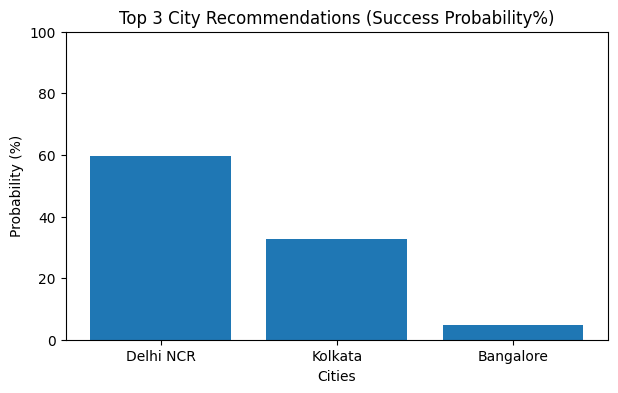

In [22]:
## Scenario 3 - Top 3 cities recommendations

# ------------------------------------------------------------
#  IMPORTS
# ------------------------------------------------------------
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# ------------------------------------------------------------
#  LOAD AND CLEAN THE DATAFRAME
# ------------------------------------------------------------
df['City'] = df['City'].str.strip()
df['Cuisine'] = df['Cuisine'].str.strip()

# ------------------------------------------------------------
#  LABEL ENCODING
# ------------------------------------------------------------
le_city = LabelEncoder()
le_cuisine = LabelEncoder()

df['City_encoded'] = le_city.fit_transform(df['City'])
df['Cuisine_encoded'] = le_cuisine.fit_transform(df['Cuisine'])

# ------------------------------------------------------------
#  FEATURE AND TARGET SELECTION
# ------------------------------------------------------------
X = df[['Cuisine_encoded', 'Ratings', 'sales_qty', 'sales_amount',
        'year', 'month']]

y = df['City_encoded']

# ------------------------------------------------------------
#  STRATIFIED SHUFFLE SPLIT
# ------------------------------------------------------------
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, test_idx in split.split(df, df['City_encoded']):
    X_train = X.iloc[train_idx]
    X_test = X.iloc[test_idx]
    y_train = y.iloc[train_idx]
    y_test = y.iloc[test_idx]

# ------------------------------------------------------------
#  TRAIN MULTI-CLASS CITY RECOMMENDATION MODEL
# ------------------------------------------------------------
model_city = RandomForestClassifier(
    n_estimators=300,
    random_state=42
)

model_city.fit(X_train, y_train)

# ------------------------------------------------------------
#  MODEL EVALUATION
# ------------------------------------------------------------
y_pred = model_city.predict(X_test)

print("\n-------------------------")
print("MODEL PERFORMANCE")
print("-------------------------")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# ------------------------------------------------------------
#  CITY RECOMMENDATION FUNCTION (INCLUDES USER CITY CHECK)
# ------------------------------------------------------------
def recommend_best_cities(cuisine, rating, qty, amount, year, month, user_city=None):

    # Encode inputs
    cuisine_encoded = le_cuisine.transform([cuisine])[0]

    sample = pd.DataFrame({
        'Cuisine_encoded': [cuisine_encoded],
        'Ratings': [rating],
        'sales_qty': [qty],
        'sales_amount': [amount],
        'year': [year],
        'month': [month]
    })

    # Predict probabilities
    probs = model_city.predict_proba(sample)[0]

    # ------------------------------
    # 1️⃣ USER SELECTED CITY PROBABILITY
    # ------------------------------
    if user_city is not None:
        try:
            user_city_encoded = le_city.transform([user_city])[0]
            user_city_prob = probs[user_city_encoded] * 100
            print("\n-------------------------------")
            print(f"USER-SELECTED CITY → {user_city}")
            print("-------------------------------")
            print(f"Success Probability in {user_city}: {(user_city_prob)}%")
        except:
            print(f"\n⚠ ERROR: '{user_city}' is not found in the trained city list.")

    # ------------------------------
    # 2️⃣ TOP 3 CITY RECOMMENDATIONS
    # ------------------------------
    top3_idx = np.argsort(probs)[-3:][::-1]
    top3_cities = le_city.inverse_transform(top3_idx)
    top3_probs = (probs[top3_idx] * 100).round(2)

    print("\n-------------------------------")
    print("TOP 3 RECOMMENDED CITIES")
    print("-------------------------------")
    for i in range(3):
        print(f"{i+1}. {top3_cities[i]}  ({top3_probs[i]}%)")

    # ------------------------------
    # 3️⃣ PLOT — TOP 3 CITY PROBABILITIES
    # ------------------------------
    plt.figure(figsize=(7, 4))
    plt.bar(top3_cities, top3_probs)
    plt.title("Top 3 City Recommendations (Success Probability%)")
    plt.xlabel("Cities")
    plt.ylabel("Probability (%)")
    plt.ylim(0, 100)
    plt.show()


# ------------------------------------------------------------
#  TEST THE FUNCTION
# ------------------------------------------------------------
recommend_best_cities(
    cuisine="Momos",
    rating=4.5,
    qty=20,
    amount=1500,
    year=2024,
    month=7,
    user_city="Delhi NCR"
)


In [14]:
df['City'].unique()

array(['Kolkata', 'Bangalore', 'Chennai', 'Delhi NCR', 'Kanpur', 'Trichy',
       'Varanasi', 'Delhi', 'Mangalore', 'Bikenere', 'Kochi', 'Bhopal',
       'Allahabad', 'Port-Blair', 'Nashik', 'Jamshedpur', 'Bengaluru',
       'Darjeeling', 'Gandhinagar', 'Lucknow', 'Gangtok', 'Nanital',
       'Kota', 'Panaji', 'Shimla', 'Pune', 'Srinagar', 'Vaddodra',
       'Itanagar', 'Surat', 'Vijaywada', 'Bhubeneshwar', 'Vellore',
       'Trivandrum', 'Siliguri', 'Ahmedabad', 'Hyderabad', 'Mysore',
       'Patna', 'Amritsar'], dtype=object)


----------------------------
RESTAURANT SUCCESS MODEL
----------------------------
Accuracy: 1.0

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7688
           1       1.00      1.00      1.00      6225

    accuracy                           1.00     13913
   macro avg       1.00      1.00      1.00     13913
weighted avg       1.00      1.00      1.00     13913


----------------------------
SUCCESS PROBABILITY RESULT
----------------------------
Success Probability: 34.67%


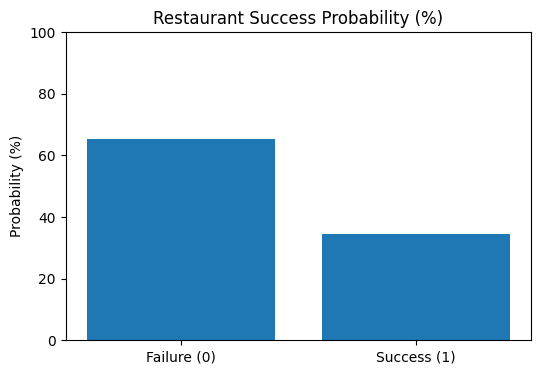

34.66666666666667

In [45]:
## Sceanrio 4 - Success Probability for the business. 


# ------------------------------------------------------------
#  IMPORTS
# ------------------------------------------------------------
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# ------------------------------------------------------------
#  1. CLEAN COLUMNS
# ------------------------------------------------------------
df['City'] = df['City'].str.strip()
df['Cuisine'] = df['Cuisine'].str.strip()

# ------------------------------------------------------------
#  2. DEFINE SUCCESS COLUMN
# ------------------------------------------------------------
df['Success'] = np.where(
    (df['Ratings'] >= 3.7) & (df['sales_amount'] >= 700),
    1, 
    0
)

# ------------------------------------------------------------
#  3. LABEL ENCODING
# ------------------------------------------------------------
le_city = LabelEncoder()
le_cuisine = LabelEncoder()

df['City_encoded'] = le_city.fit_transform(df['City'])
df['Cuisine_encoded'] = le_cuisine.fit_transform(df['Cuisine'])

# ------------------------------------------------------------
#  4. FEATURE SELECTION
# ------------------------------------------------------------
X = df[['Ratings', 'sales_qty', 'sales_amount',
        'City_encoded', 'Cuisine_encoded',
        'year', 'month']]

y = df['Success']

# ------------------------------------------------------------
#  5. STRATIFIED SPLIT
# ------------------------------------------------------------
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, test_idx in split.split(df, df['Success']):
    X_train = X.iloc[train_idx]
    y_train = y.iloc[train_idx]
    X_test = X.iloc[test_idx]
    y_test = y.iloc[test_idx]

# ------------------------------------------------------------
#  6. TRAIN SUCCESS MODEL
# ------------------------------------------------------------
model_success = RandomForestClassifier(
    n_estimators=300,
    random_state=42
)

model_success.fit(X_train, y_train)

# ------------------------------------------------------------
#  7. EVALUATE MODEL
# ------------------------------------------------------------
y_pred = model_success.predict(X_test)

print("\n----------------------------")
print("RESTAURANT SUCCESS MODEL")
print("----------------------------")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


# ------------------------------------------------------------
#  8. PREDICT SUCCESS PROBABILITY FUNCTION
# ------------------------------------------------------------
def predict_success_probability(rating, qty, amount, cuisine, city, year, month):

    city_encoded = le_city.transform([city])[0]
    cuisine_encoded = le_cuisine.transform([cuisine])[0]

    sample = pd.DataFrame({
        'Ratings': [rating],
        'sales_qty': [qty],
        'sales_amount': [amount],
        'City_encoded': [city_encoded],
        'Cuisine_encoded': [cuisine_encoded],
        'year': [year],
        'month': [month]
    })

    probs = model_success.predict_proba(sample)[0]
    success_prob = probs[1] * 100   # probability restaurant = successful

    print("\n----------------------------")
    print("SUCCESS PROBABILITY RESULT")
    print("----------------------------")
    print(f"Success Probability: {success_prob:.2f}%")

    # ------------- Plot Probability -------------
    labels = ['Failure (0)', 'Success (1)']
    values = probs * 100

    plt.figure(figsize=(6,4))
    plt.bar(labels, values)
    plt.ylim(0, 100)
    plt.title("Restaurant Success Probability (%)")
    plt.ylabel("Probability (%)")
    plt.show()

    return success_prob


# ------------------------------------------------------------
#  9. TEST PREDICTION
# ------------------------------------------------------------
predict_success_probability(
    rating=4.1,
    qty=20,
    amount=150,
    cuisine="North Indian",
    city="Kolkata",
    year=2025,
    month=7
)



----------------------------
BEST MONTH MODEL PERFORMANCE
----------------------------
Accuracy: 0.07963774886796521

Classification Report:

              precision    recall  f1-score   support

           1       0.08      0.09      0.08      1185
           2       0.08      0.07      0.07      1058
           3       0.07      0.07      0.07      1186
           4       0.09      0.10      0.10      1148
           5       0.07      0.07      0.07      1158
           6       0.07      0.07      0.07      1122
           7       0.09      0.09      0.09      1198
           8       0.08      0.08      0.08      1178
           9       0.07      0.07      0.07      1159
          10       0.08      0.08      0.08      1180
          11       0.09      0.08      0.09      1152
          12       0.09      0.09      0.09      1189

    accuracy                           0.08     13913
   macro avg       0.08      0.08      0.08     13913
weighted avg       0.08      0.08      0.08  

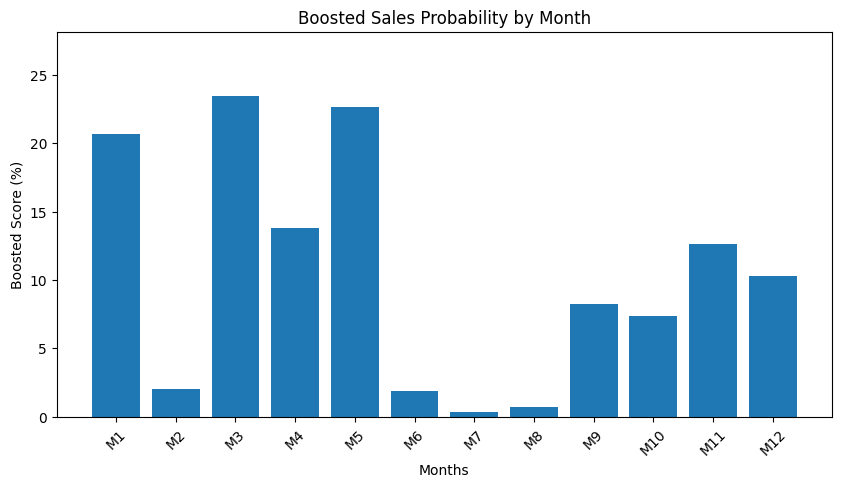

(array([3, 5, 1], dtype=int64),
 array([20.7       ,  2.        , 23.45      , 13.8       , 22.61666667,
         1.91666667,  0.35      ,  0.7       ,  8.21666667,  7.36666667,
        12.6       , 10.26666667]))

In [49]:
## Scenario 5 - Best Monthly sales recommendations and why 


import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1. CLEAN & ENCODE DATA
# ------------------------------------------------------------
df['City'] = df['City'].str.strip()
df['Cuisine'] = df['Cuisine'].str.strip()

le_city = LabelEncoder()
le_cuisine = LabelEncoder()

df['City_encoded'] = le_city.fit_transform(df['City'])
df['Cuisine_encoded'] = le_cuisine.fit_transform(df['Cuisine'])

# ------------------------------------------------------------
# 2. TARGET (MONTH)
# ------------------------------------------------------------
y = df['month']

# ------------------------------------------------------------
# 3. FEATURES FOR PREDICTING BEST MONTH
# ------------------------------------------------------------
X = df[['Ratings', 'sales_qty', 'sales_amount',
        'City_encoded', 'Cuisine_encoded', 'year']]

# ------------------------------------------------------------
# 4. STRATIFIED SPLIT BASED ON MONTH
# ------------------------------------------------------------
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, test_idx in split.split(df, df['month']):
    X_train = X.iloc[train_idx]
    y_train = y.iloc[train_idx]
    X_test = X.iloc[test_idx]
    y_test = y.iloc[test_idx]

# ------------------------------------------------------------
# 5. TRAIN MODEL (RANDOM FOREST CLASSIFIER)
# ------------------------------------------------------------
model_month = RandomForestClassifier(
    n_estimators=300,
    random_state=42
)

model_month.fit(X_train, y_train)

# ------------------------------------------------------------
# 6. EVALUATE MODEL
# ------------------------------------------------------------
y_pred = model_month.predict(X_test)

print("\n----------------------------")
print("BEST MONTH MODEL PERFORMANCE")
print("----------------------------")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))
# ------------------------------------------------------------
# FESTIVAL BOOST (India-specific)
# ------------------------------------------------------------
def get_festival_boost(month):
    festival_boost = {
        10: 0.25,   # October - Diwali / Durga Puja
        11: 0.20,   # November - Diwali season
        9: 0.15,    # September - Pujo build up
        12: 0.20,   # Christmas
        1: 0.15,    # New Year
        4: 0.10, 5: 0.10, 6: 0.10  # Summer holiday boost
    }
    return festival_boost.get(month, 0)
    

# ------------------------------------------------------------
# CUISINE-SEASON BOOST
# ------------------------------------------------------------
def get_cuisine_boost(cuisine, month):
    cuisine = cuisine.lower()
    
    summer = [4, 5, 6]
    winter = [10, 11, 12, 1, 2]
    
    if "ice" in cuisine or "juice" in cuisine:
        return 0.35 if month in summer else 0
    
    if "chinese" in cuisine:
        return 0.15 if month in winter else 0
    
    if "biryani" in cuisine:
        return 0.05
    
    if "street" in cuisine:
        return 0.20 if month in winter else 0
    
    if "beverage" in cuisine:
        return 0.25 if month in summer else 0
    
    return 0.05  # default small boost


# ------------------------------------------------------------
# CITY-SEASONALITY BOOST
# ------------------------------------------------------------
def get_city_boost(city, month):
    city = city.lower()
    
    if city == "kolkata" and month in [9, 10]:
        return 0.30  # Pujo
    
    if city == "bangalore" and month in [12]:
        return 0.20  # Tech crowd holidays
    
    if city == "chennai" and month in [4, 5, 6]:
        return 0.20  # Hot weather cold drink demand
    
    if city == "delhi" and month in [11, 12, 1]:
        return 0.25  # Winter demand
    
    return 0.05  # default boost


# ------------------------------------------------------------
# FINAL BEST MONTH FUNCTION
# ------------------------------------------------------------
def recommend_best_month_enhanced(cuisine, rating, qty, amount, city, year):

    city_encoded = le_city.transform([city])[0]
    cuisine_encoded = le_cuisine.transform([cuisine])[0]

    sample = pd.DataFrame({
        'Ratings': [rating],
        'sales_qty': [qty],
        'sales_amount': [amount],
        'City_encoded': [city_encoded],
        'Cuisine_encoded': [cuisine_encoded],
        'year': [year]
    })

    # ML probabilities → 12 months
    base_probs = model_month.predict_proba(sample)[0] * 100

    # APPLY BOOSTS
    boosted_scores = []
    for month in range(1, 13):
        boost = (
            get_festival_boost(month) +
            get_cuisine_boost(cuisine, month) +
            get_city_boost(city, month)
        )
        boosted_scores.append(base_probs[month-1] * (1 + boost))

    boosted_scores = np.array(boosted_scores)

    # TOP 3 MONTHS
    top3_idx = np.argsort(boosted_scores)[-3:][::-1]
    top3_months = top3_idx + 1

    print("\n------------------------------")
    print("TOP 3 BEST MONTHS (Enhanced)")
    print("------------------------------")
    for i in range(3):
        print(f"{i+1}. Month {top3_months[i]} (Score: {boosted_scores[top3_idx[i]]:.2f})")

    # COMBINED GRAPH
    months = [f"M{m}" for m in range(1, 13)]

    plt.figure(figsize=(10, 5))
    plt.bar(months, boosted_scores)
    plt.title("Boosted Sales Probability by Month")
    plt.xlabel("Months")
    plt.ylabel("Boosted Score (%)")
    plt.xticks(rotation=45)
    plt.ylim(0, max(boosted_scores) * 1.2)
    plt.show()

    return top3_months, boosted_scores


recommend_best_month_enhanced(
    cuisine="Chinese",
    rating=4.5,
    qty=15,
    amount=1200,
    city="Kolkata",
    year=2024
)